# IRAY NNK selection

### Overview
* Did single site saturation mutagenesis on AMK-1057 including the IRAY upstream
* ran a gradient of AHL (prey) and Cm levels
* tried to pick a few different samples after selection
    * aimed for low AHL expression that still survived selection (could be tighter binders)
* sequenced the parental library 2x to try and get better coverage

### Samples
Sample | Description
---|---
1_slDAA263_1 | pre-selection library in RBD system replicate 1
2_slDAA263_2 | pre-selection library in RBD system replicate 2
3_slDAA264 | pre-selection library in mdm2 system
4_slDAA265 | RBD library; 0.00032uM AHL, 250uM Cm
5_slDAA266 | RBD library; 0.008uM AHL, 1000uM Cm
6_slDAA267 | RBD library; 1uM AHL, 1000uM Cm (standard selection conditions)
7_slDAA268 | RBD library; 1uM AHL, 1000uM Cm (standard selection conditions)

### Analysis approach
* enumerate each unique variant
* calculate enrichment between selected library and parental
    * divide fraction reads by each other
* cross-checks / QC
    * make sure the two parental libraries have similar distributions
    * check observed fraction of reads in each library to make sure there's coverage
    * look to see if any variants are enriched in the mdm2 library (to check for non-specificity)
* look for better binders
    * look for variants that enrich in low AHL conditions (perhaps more than high AHL conditions)

In [1]:
import glob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq

In [2]:
sns.__version__

'0.11.0'

In [3]:
import matplotlib
matplotlib.rc('figure', dpi = 150)
sns.set_style('ticks')

## Pre-processing

### Splitting files
* have to split MGH crispr sequencing files into forward and reverse reads (us a script in "paired end.ipynb"

### Paired end alignment
Used pandaseq on Saffron (since i couldn't figure out how to install it myself). Only kept perfect matches


## Import sequences

In [4]:
files = [f for f in glob.glob('./data/aligned/*_paired*')]

In [5]:
files

['./data/aligned\\1_slDAA263_1_322656w_BG12_paired_no-mismatches.fastq',
 './data/aligned\\2_slDAA263_2_322656w_BH1_paired_no-mismatches.fastq',
 './data/aligned\\3_slDAA264_322656w_BH2_paired_no-mismatches.fastq',
 './data/aligned\\4_slDAA265_322656w_BH3_paired_no-mismatches.fastq',
 './data/aligned\\5_slDAA266_322656w_BH4_paired_no-mismatches.fastq',
 './data/aligned\\6_slDAA267_322656w_BH5_paired_no-mismatches.fastq',
 './data/aligned\\7_slDAA268_322656w_BH6_paired_no-mismatches.fastq']

In [6]:
# Read in the fastq files. Keep the id and sequence for each read, and sample ID

d = {'id': [], 'seq': [], 'sample' : []}

for file in files:
    for seq_record in SeqIO.parse(file, "fastq"):
        #print(seq_record.name)
        d['sample'].append(re.findall(r'\d_slDAA\d+.*_32', file)[0][0:-3])
        d['id'].append(seq_record.id)
        d['seq'].append(seq_record.seq)
    
seq_data = pd.DataFrame(data=d)

In [7]:
seq_data['sample'].unique()

array(['1_slDAA263_1', '2_slDAA263_2', '3_slDAA264', '4_slDAA265',
       '5_slDAA266', '6_slDAA267', '7_slDAA268'], dtype=object)

### Flip reverse seqs

Flip sequences that have the reverse complement of the sequence right next to the core in them such that they all reads are in the sense direction

In [8]:
flip_str = 'AAAGTACAGGTTTT'
def count_flips(seq):
    if seq.find(flip_str) != -1:
        return(True)
    else:
        return(False)
    
def flip_seq(seq):
    if seq.find(flip_str) != -1:
        return(seq.reverse_complement())
    else:
        return(seq)

seq_data['flipped'] = seq_data['seq'].apply(count_flips)
seq_data['seq'] = seq_data['seq'].apply(flip_seq)

In [9]:
seq_data['flipped'].value_counts()

False    208160
True     195629
Name: flipped, dtype: int64

In [10]:
seq_data.head()

,id,seq,sample,flipped
0,M02846:177:000000000-JBGTB:1:1101:21980:3721:1,"(A, T, G, C, T, G, A, A, G, C, A, G, A, T, T, ...",1_slDAA263_1,True
1,M02846:177:000000000-JBGTB:1:1101:18829:3712:1,"(A, T, G, C, T, G, A, A, G, C, A, G, A, T, T, ...",1_slDAA263_1,False
2,M02846:177:000000000-JBGTB:1:1101:14741:3724:1,"(A, T, G, C, T, G, A, A, G, C, A, G, A, T, T, ...",1_slDAA263_1,True
3,M02846:177:000000000-JBGTB:1:1101:17502:3734:1,"(A, T, G, C, T, G, A, A, G, C, T, G, A, T, T, ...",1_slDAA263_1,False
4,M02846:177:000000000-JBGTB:1:1101:14043:3743:1,"(G, T, G, C, C, G, G, A, C, G, G, G, T, A, T, ...",1_slDAA263_1,False


In [11]:
seq_data.groupby(['sample'])['seq'].agg(['count'])

,count
sample,
1_slDAA263_1,68508
2_slDAA263_2,55054
3_slDAA264,54493
4_slDAA265,52133
5_slDAA266,39078
6_slDAA267,66132
7_slDAA268,68391


50K + reads for each sample. A bit less for slDAA266 for some reason.

#### Extract the core sequences

In [12]:
# Sequence downstream of library (use downstream since its in the read overlapping region and thus has error correction)
downstream_seq = 'CGAGGAGGTA'

# Size of library
library_len = 51

def extract_core(seq):
    core_start = seq.find(downstream_seq)
    if core_start != -1:     #if we find the upstream sequence
        core_seq = seq[(core_start - library_len) : core_start]
    else:
        core_seq = None
    return(core_seq)

seq_data['core_seq'] = seq_data['seq'].apply(extract_core)

def fntranslate(seq): # a function that wraps the translate function so it never tries to trnslate 'Fail'
    if seq== None:
        return None
    else:
        return seq.translate()

# Translate cores
seq_data['tl'] = seq_data['core_seq'].apply(fntranslate)
seq_data.head()

,id,seq,sample,flipped,core_seq,tl
0,M02846:177:000000000-JBGTB:1:1101:21980:3721:1,"(A, T, G, C, T, G, A, A, G, C, A, G, A, T, T, ...",1_slDAA263_1,True,"(A, T, A, C, G, C, G, C, G, T, A, C, G, T, G, ...","(I, R, A, Y, V, C, K, Y, P, E, W, C, E, I, V, ..."
1,M02846:177:000000000-JBGTB:1:1101:18829:3712:1,"(A, T, G, C, T, G, A, A, G, C, A, G, A, T, T, ...",1_slDAA263_1,False,"(A, T, A, A, C, G, G, C, G, T, A, C, G, T, G, ...","(I, T, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ..."
2,M02846:177:000000000-JBGTB:1:1101:14741:3724:1,"(A, T, G, C, T, G, A, A, G, C, A, G, A, T, T, ...",1_slDAA263_1,True,"(A, T, A, C, G, C, G, C, G, T, C, T, G, T, G, ...","(I, R, A, S, V, C, K, Y, G, E, W, C, E, I, V, ..."
3,M02846:177:000000000-JBGTB:1:1101:17502:3734:1,"(A, T, G, C, T, G, A, A, G, C, T, G, A, T, T, ...",1_slDAA263_1,False,"(A, T, A, A, T, T, G, C, G, T, A, C, G, T, G, ...","(I, I, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ..."
4,M02846:177:000000000-JBGTB:1:1101:14043:3743:1,"(G, T, G, C, C, G, G, A, C, G, G, G, T, A, T, ...",1_slDAA263_1,False,None,None


In [13]:
# Collapse all multiply-observed DNA sequences onto each other
grouped_df = seq_data.groupby(['sample', 'core_seq', 'tl']).size().reset_index(name='counts')
grouped_df.head()

,sample,core_seq,tl,counts
0,1_slDAA263_1,(),(),4
1,1_slDAA263_1,"(A, A, A, A, C, C, T, G, T, A, C, T, T, T, C, ...","(K, T, C, T, F, R, V, Y, A, R, T, C, E, I, V, ...",1
2,1_slDAA263_1,"(A, A, A, A, C, C, T, G, T, A, C, T, T, T, C, ...","(K, T, C, T, F, R, V, Y, A, R, T, C, V, K, G, ...",1
3,1_slDAA263_1,"(A, A, A, C, C, T, G, T, A, C, T, T, T, C, A, ...","(K, P, V, L, S, G, Y, T, R, V, W, C, E, I, V, ...",1
4,1_slDAA263_1,"(A, A, A, C, G, C, G, C, G, T, A, C, G, T, G, ...","(K, R, A, Y, V, C, K, Y, G, E, S, C, E, I, V, ...",1


In [14]:
#grouped_df.to_pickle('20201213_iray_nnk_grouped_df.bz2')
grouped_df = pd.read_pickle('20201213_iray_nnk_grouped_df.bz2')

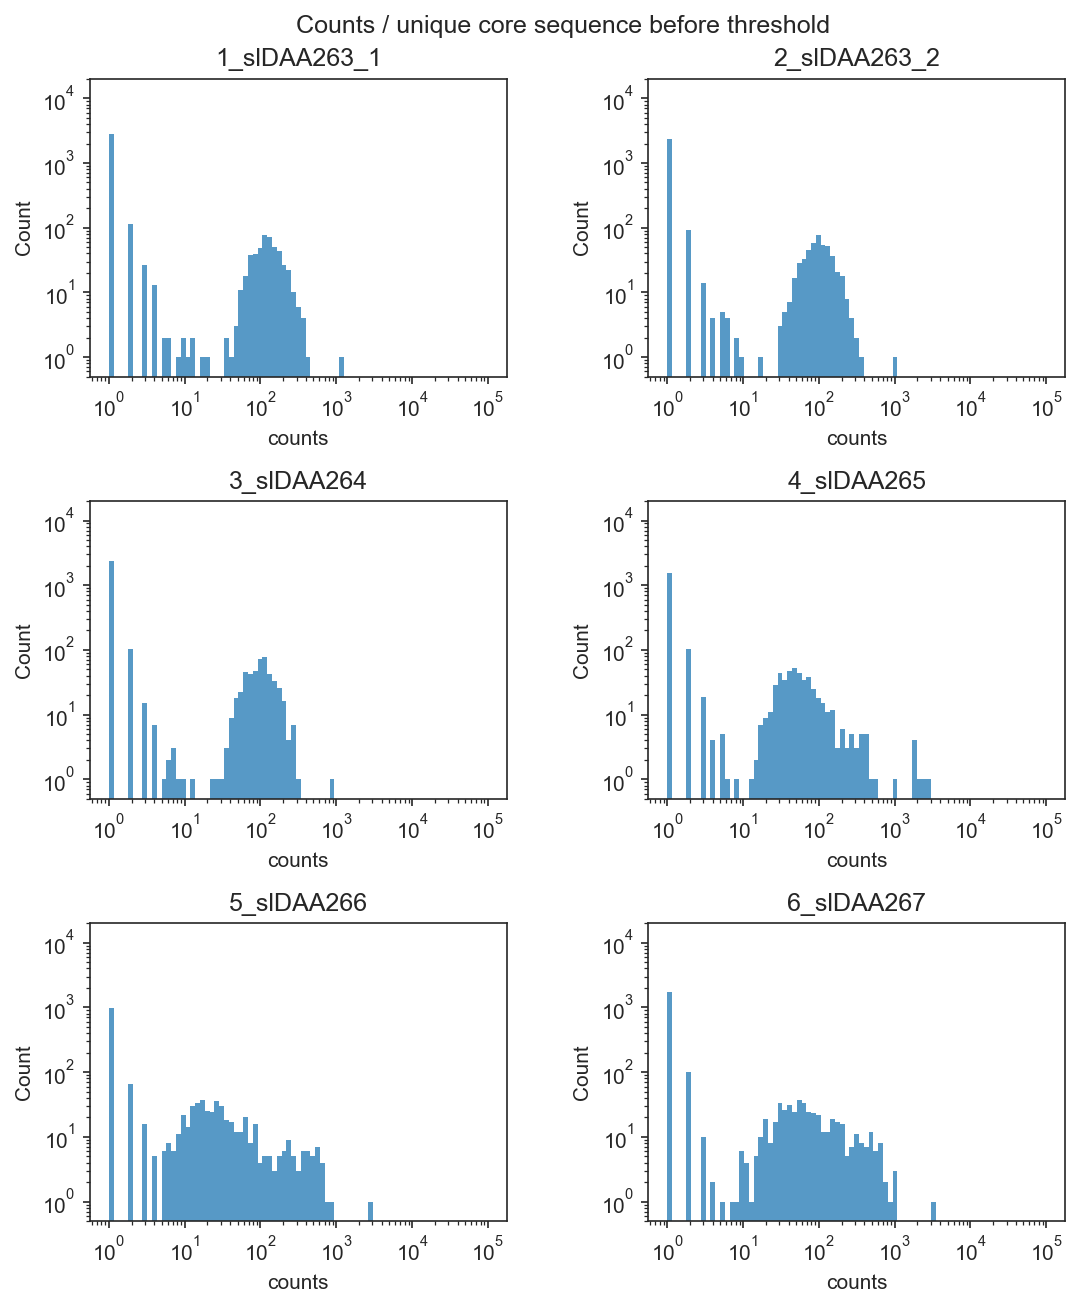

In [15]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (8,9))
fig.tight_layout(pad = 4)

samples = grouped_df['sample'].unique()

for sample, ax in zip(samples,axs.flatten()): 
    sub_df = grouped_df[grouped_df['sample'] == sample]
    
    sns.histplot(data = sub_df, x = 'counts', ax = ax, bins=np.logspace(0, 5, 80))
    
    ax.set_title(sample)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(5e-1,2e4)

fig.suptitle('Counts / unique core sequence before threshold')
plt.show()

Use 10 counts as a cutoff for unique core sequences

In [16]:
count_thr = 5
cleaned_df = grouped_df[grouped_df['counts'] >= count_thr]

In [17]:
print('Unique cores before: {} \nUnique cores after filter: {}'.format(grouped_df['core_seq'].nunique(),cleaned_df['core_seq'].nunique()))

Unique cores before: 13437 
Unique cores after filter: 493


There should only be 32*14 = 448 unique core DNA sequences

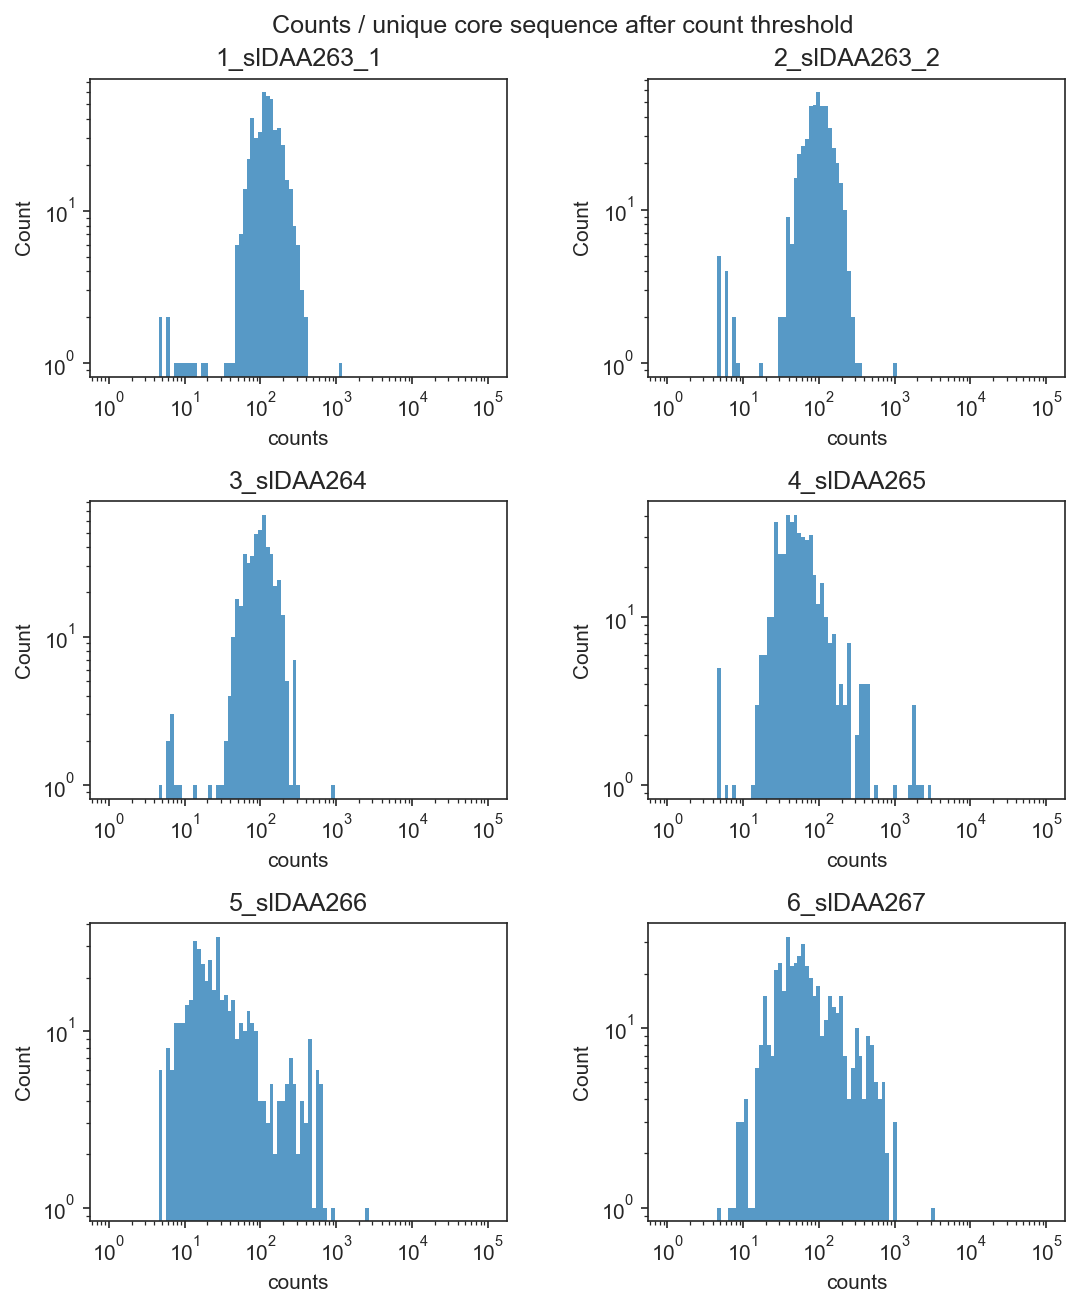

In [18]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (8,9))
fig.tight_layout(pad = 4)

samples = grouped_df['sample'].unique()

for sample, ax in zip(samples,axs.flatten()): 
    sub_df = cleaned_df[cleaned_df['sample'] == sample]
    
    sns.histplot(data = sub_df, x = 'counts', ax = ax, bins=np.logspace(0, 5, 100))
    
    ax.set_title(sample)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
fig.suptitle('Counts / unique core sequence after count threshold')
plt.show()

### Calculate fraction of total reads for each sequence

In [19]:
# Calculate total reads before any binning and pruning
full_counts = seq_data.groupby(['sample']).size()
full_counts

sample
1_slDAA263_1    68508
2_slDAA263_2    55054
3_slDAA264      54493
4_slDAA265      52133
5_slDAA266      39078
6_slDAA267      66132
7_slDAA268      68391
dtype: int64

In [20]:
cleaned_df['frac_reads'] = cleaned_df.apply(lambda x: x['counts'] / full_counts[x['sample']], axis = 1)

C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
cleaned_df.head()

,sample,core_seq,tl,counts,frac_reads
7,1_slDAA263_1,"(A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(K, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",98,0.001430
17,1_slDAA263_1,"(A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, ...","(N, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",124,0.001810
45,1_slDAA263_1,"(A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",180,0.002627
60,1_slDAA263_1,"(A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, ...","(T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",182,0.002657
75,1_slDAA263_1,"(A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(R, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",77,0.001124


In [22]:
## Check the top fractional values for each
cleaned_df.sort_values(['sample', 'frac_reads'], ascending = [True,False]).groupby('sample').head(3).style.set_properties(**{"font-family": 'monospace'})

,sample,core_seq,tl,counts,frac_reads
1291,1_slDAA263_1,ATACGCGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IRAYVCKYGEWCEIVEI,1185,0.017297
256,1_slDAA263_1,ATACCTGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IPAYVCKYGEWCEIVEI,414,0.006043
1297,1_slDAA263_1,ATACGCGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAACCT,IRAYVCKYGEWCEIVEP,377,0.005503
4598,2_slDAA263_2,ATACGCGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IRAYVCKYGEWCEIVEI,979,0.017783
3693,2_slDAA263_2,ATACCTGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IPAYVCKYGEWCEIVEI,348,0.006321
4645,2_slDAA263_2,ATACGCGCGTACGTGTGTAAATATGGTGAATGGTGTGAGCCTGTCGAAATC,IRAYVCKYGEWCEPVEI,300,0.005449
7552,3_slDAA264,ATACGCGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IRAYVCKYGEWCEIVEI,924,0.016956
6667,3_slDAA264,ATACCTGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IPAYVCKYGEWCEIVEI,305,0.005597
6657,3_slDAA264,ATACCGGCGTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IPAYVCKYGEWCEIVEI,290,0.005322
10754,4_slDAA265,ATACGCGTTTACGTGTGTAAATATGGTGAATGGTGTGAGATCGTCGAAATC,IRVYVCKYGEWCEIVEI,2810,0.053901


## Calculate all possible variants

In [23]:
# List of AA substitution possibilities
aas = 'ARNDCQEGHILKMFPSTWYV*'
parent = 'IRAYVCKYGEWCEIVEI'

# Keep track of all variants
var_names = [] # name them human readable
var_seqs = [] # create list of AA variants for a position
poss = [] # Keep track of the position
subs = [] # Keep track of the substitution completed

# iterate through each position and substitute each aa
for pos in range(len(parent)):    
    for aa in aas:

        new_var = parent[0:pos] + aa + parent[pos+1:]  # Substitute in amino acid
        var_name = parent[pos] + str(pos+1) + aa # name it in a human readable format

        var_names.append(var_name)
        var_seqs.append(new_var)
        poss.append(pos+1)
        subs.append(aa)


d = {'var_name': var_names, 'var_tl':var_seqs, 'var_pos': poss, 'var_sub': subs}
var_df = pd.DataFrame(d)
var_df

,var_name,var_tl,var_pos,var_sub
0,I1A,ARAYVCKYGEWCEIVEI,1,A
1,I1R,RRAYVCKYGEWCEIVEI,1,R
2,I1N,NRAYVCKYGEWCEIVEI,1,N
3,I1D,DRAYVCKYGEWCEIVEI,1,D
4,I1C,CRAYVCKYGEWCEIVEI,1,C
...,...,...,...,...
352,I17T,IRAYVCKYGEWCEIVET,17,T
353,I17W,IRAYVCKYGEWCEIVEW,17,W
354,I17Y,IRAYVCKYGEWCEIVEY,17,Y
355,I17V,IRAYVCKYGEWCEIVEV,17,V


## Check initial library biases
* Compare the two replicates of the RBD parent

In [24]:
# Reindex on sequence for faster computation
reidx_all_df = cleaned_df.set_index(['sample', 'core_seq'])
reidx_all_df.head()

tl  \
sample       core_seq                                                                                                
1_slDAA263_1 (A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, T...  (K, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, T...  (N, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, T...  (T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, T...  (T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, T...  (R, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   

                                                                 counts  \
sample       core_seq                                                     
1_slDAA263_1 (A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, T...      98   
             (A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, T...     124   
             (A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, T...     180   
             (A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, T...     182   
             (A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, T...      77   

                                                                 frac_reads  
sample       core_seq                                                        
1_slDAA263_1 (A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.001430  
             (A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.001810  
             (A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.002627  
             (A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.002657  
             (A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.001124

In [25]:
seq_data['sample'].unique()

array(['1_slDAA263_1', '2_slDAA263_2', '3_slDAA264', '4_slDAA265',
       '5_slDAA266', '6_slDAA267', '7_slDAA268'], dtype=object)

In [26]:
def plt_bias(sample):
    
    sample_df = reidx_all_df.loc[sample].reset_index()
    sample_df.head()

    # Merge on translations take the mean fraction and pivot
    merge_df = pd.merge(var_df, sample_df, how = 'left', left_on = 'var_tl', right_on = 'tl')

    ## First w/ need to take the mean of all variants
    merge_mean = merge_df.groupby(['var_pos', 'var_sub']).mean().reset_index()
    merge_pivot = merge_mean.pivot_table(index = 'var_sub', columns = 'var_pos', values = 'frac_reads')

    fig, ax = plt.subplots(figsize = (9,11))

    sns.heatmap(merge_pivot, ax = ax, cmap = 'viridis', vmin=1e-4, vmax=1e-2,
                norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e-2), cbar_kws = {'label': 'Fraction of reads'},
               xticklabels = [a for a in parent], annot = True, fmt = '.1e', annot_kws = {'fontsize': 'x-small'} )
    ax.set_facecolor('#D9D9D9')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_yticklabels(ax.get_yticklabels(), rotation= 0)
    ax.set_xlabel('Core position')
    ax.set_ylabel('AA substitution')

    plt.show()

C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


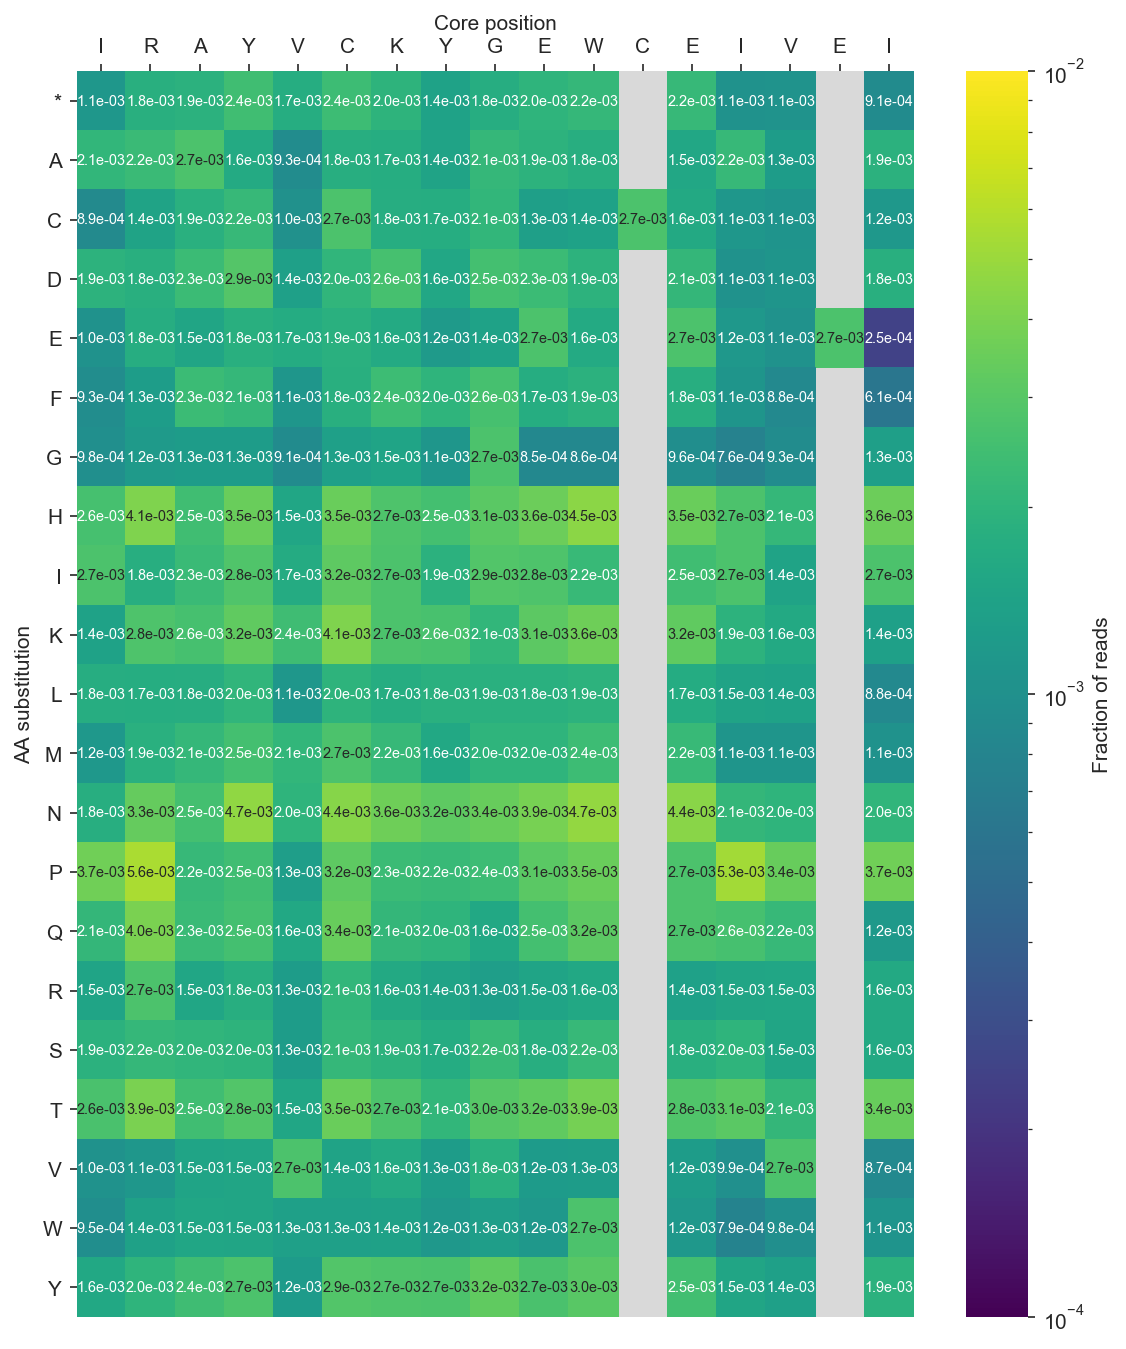

In [27]:
plt_bias('1_slDAA263_1')

C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


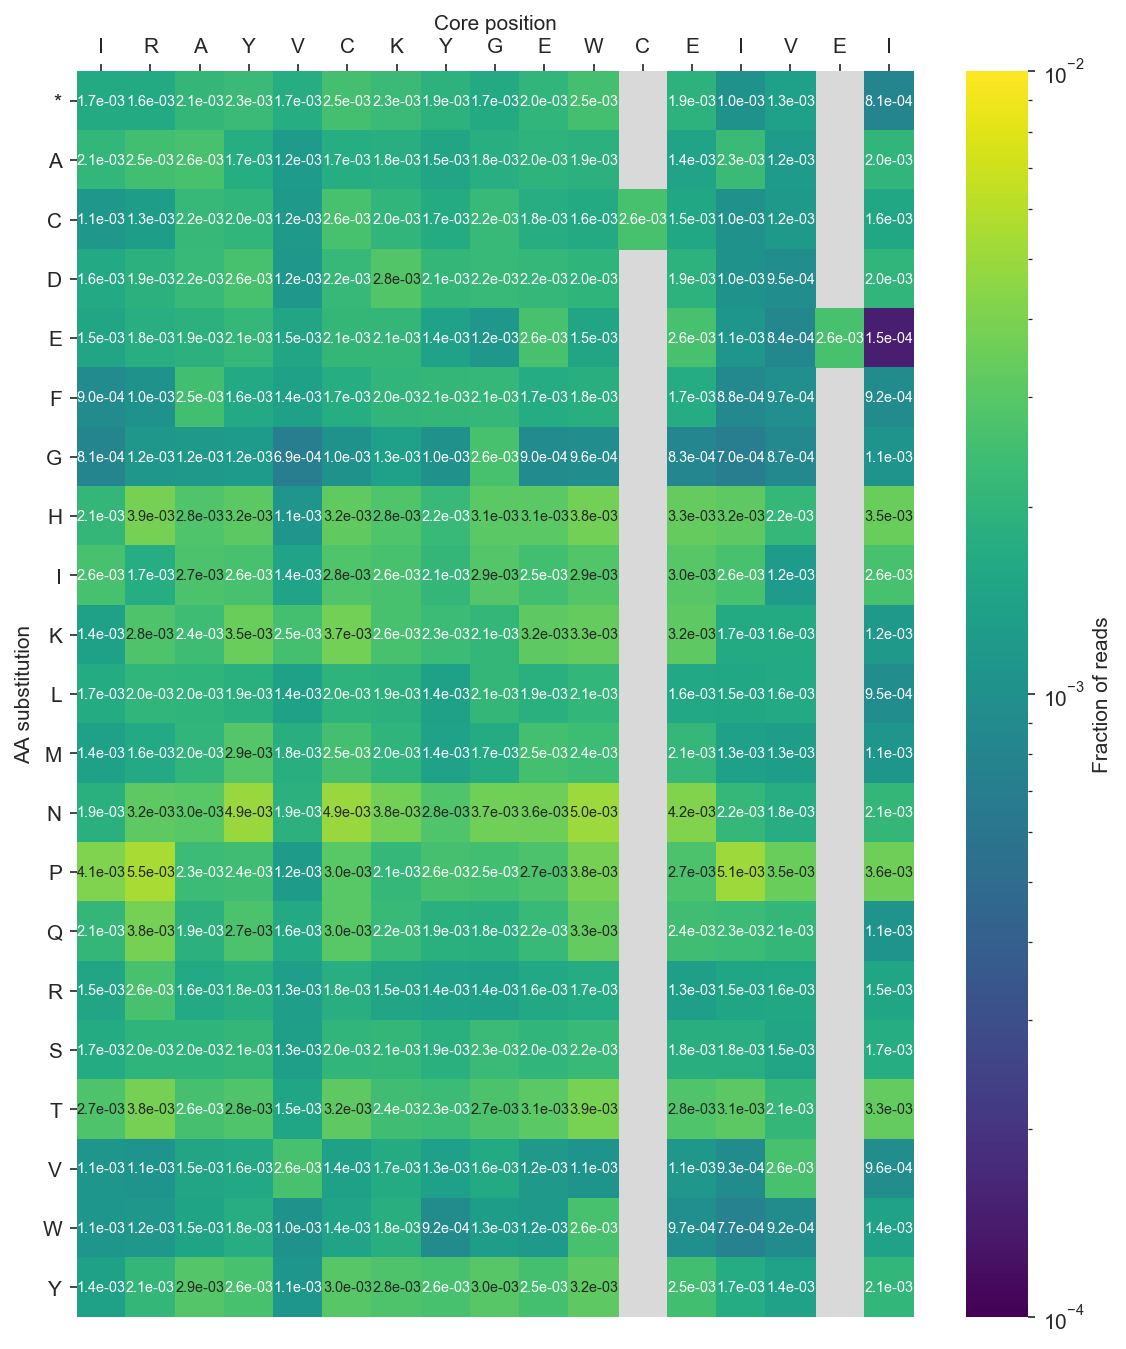

In [ ]:
plt_bias('3_slDAA264')

### Results
* both of the initial RBD libraries look to have fairly good sampling (the C-terminal depletion is gone thanks to adding more of that fragment)
* will just do all enrichment calculations w/ slDAA253_1 since it seems to have good enough sampling (don't need to combine)

## Calculate enrichments from parental

In [ ]:
# Create a dictionary mapping each sample to its parent so that enrichments can be calculated
parent_dict = {
    '1_slDAA263_1': None,
    '2_slDAA263_2': None,
    '3_slDAA264': None,
    '4_slDAA265': '1_slDAA263_1',
    '5_slDAA266': '1_slDAA263_1',
    '6_slDAA267': '1_slDAA263_1',
    '7_slDAA268': '3_slDAA264'
}

In [ ]:
enriches_df = reidx_all_df.copy()
enriches_df.head()

# Iterate through each sample and calculate the enrichment for each DNA sequence

df_list = []
for sample in seq_data['sample'].unique():
    if parent_dict[sample]:
        # Get enrichments for the given sample and make it into a dataframe
        sample_enriches = pd.DataFrame((reidx_all_df.loc[sample,'frac_reads'] / reidx_all_df.loc[parent_dict[sample],'frac_reads']).rename('enrich')).reset_index()
        sample_enriches['sample'] = sample
        sample_enriches.set_index(['sample', 'core_seq'], inplace = True)
        
        df_list.append(sample_enriches)

# Concatenate all dfs
all_sample_enriches = pd.concat(df_list)        
        
# Merge the dataframe with the enriches_df on sample and core_seq columns
enriches_df = enriches_df.join(all_sample_enriches)

In [ ]:
enriches_df.head()

tl  \
sample       core_seq                                                                                                
1_slDAA263_1 (A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, T...  (K, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, T...  (N, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, T...  (T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, T...  (T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   
             (A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, T...  (R, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...   

                                                                 counts  \
sample       core_seq                                                     
1_slDAA263_1 (A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, T...      98   
             (A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, T...     124   
             (A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, T...     180   
             (A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, T...     182   
             (A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, T...      77   

                                                                 frac_reads  \
sample       core_seq                                                         
1_slDAA263_1 (A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.001430   
             (A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.001810   
             (A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.002627   
             (A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.002657   
             (A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, T...    0.001124   

                                                                 enrich  
sample       core_seq                                                    
1_slDAA263_1 (A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, T...     NaN  
             (A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, T...     NaN  
             (A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, T...     NaN  
             (A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, T...     NaN  
             (A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, T...     NaN

In [ ]:
enriches_df.reset_index()['sample'].unique()

array(['1_slDAA263_1', '2_slDAA263_2', '3_slDAA264', '4_slDAA265',
       '5_slDAA266', '6_slDAA267', '7_slDAA268'], dtype=object)

### Look at enrichments distribution

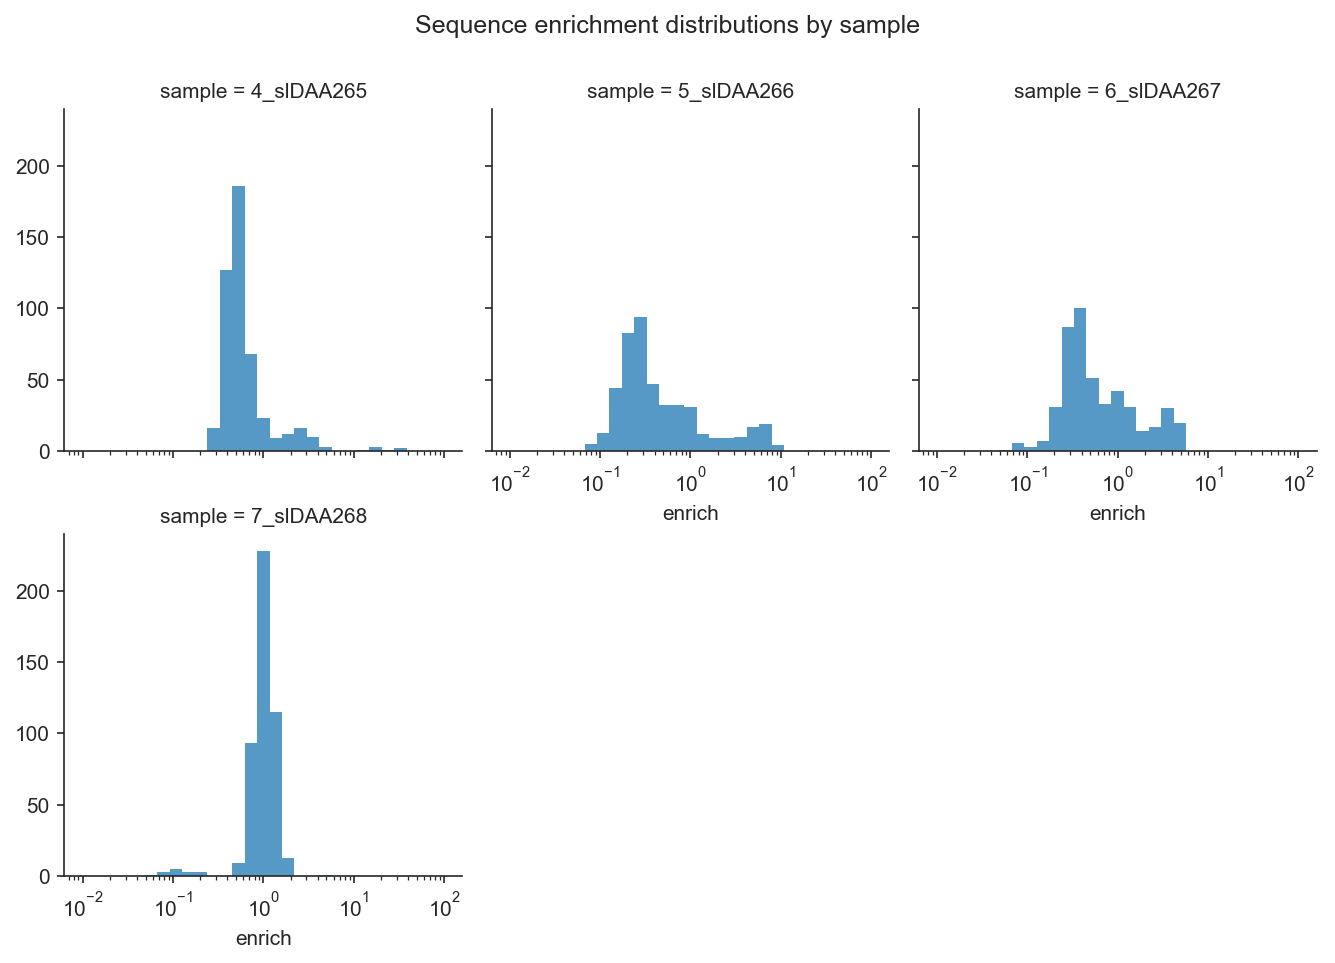

In [ ]:
g = sns.FacetGrid(enriches_df.reset_index(), col = 'sample', col_wrap=3, col_order=['4_slDAA265','5_slDAA266', '6_slDAA267', '7_slDAA268'])
g.map(sns.histplot, 'enrich', bins=np.logspace(-2, 2, 30))

g.set(xscale = 'log')
g.fig.suptitle('Sequence enrichment distributions by sample',y=1.05)
plt.show()

### Result
* looks like nothing enriches particularly well in the mdm2 sample (no non-specific enrichment)

### Look at top enrichers for each sample

In [ ]:
## Check the top fractional values for each
enriches_df.sort_values(['sample', 'enrich'], ascending = [True,False]).groupby('sample').head(10).style.set_properties(**{"font-family": 'monospace'})

### Sanity check by looking for enrichment of previously-done alanine scans

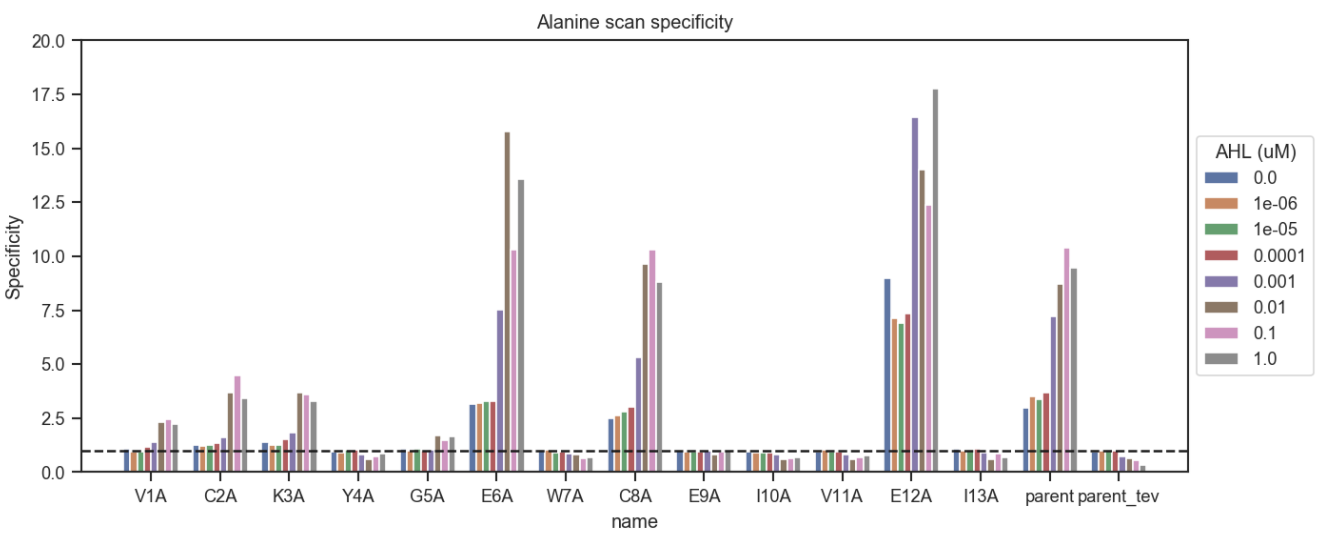

In [ ]:
# Create dataframe w/ alanine scan sequences and merge w/ enrichment_df
ala_scans = {
    'parent': 'IRAYVCKYGEWCEIVEI',
    'V1A': 'IRAYACKYGEWCEIVEI',
    'C2A': 'IRAYVAKYGEWCEIVEI',
    'K3A': 'IRAYVCAYGEWCEIVEI',
    'Y4A': 'IRAYVCKAGEWCEIVEI',
    'G5A': 'IRAYVCKYAEWCEIVEI',
    'E6A': 'IRAYVCKYGAWCEIVEI',
    'W7A': 'IRAYVCKYGEACEIVEI',
    'C8A': 'IRAYVCKYGEWAEIVEI',
    'E9A': 'IRAYVCKYGEWCAIVEI',
    'I10A': 'IRAYVCKYGEWCEAVEI',
    'V11A': 'IRAYVCKYGEWCEIAEI',
    'E12A': 'IRAYVCKYGEWCEIVAI',
    'I13A': 'IRAYVCKYGEWCEIVEA',
}

names = []
tls = []
for name, tl in ala_scans.items():
    names.append(name)
    tls.append(tl)
data = {'name': names, 'tl': tls}
    
ala_df = pd.DataFrame(data)
ala_df.head()

,name,tl
0,parent,IRAYVCKYGEWCEIVEI
1,V1A,IRAYACKYGEWCEIVEI
2,C2A,IRAYVAKYGEWCEIVEI
3,K3A,IRAYVCAYGEWCEIVEI
4,Y4A,IRAYVCKAGEWCEIVEI


In [ ]:
sub_df = enriches_df.loc['6_slDAA267']

In [ ]:
ala_enrich_df = pd.merge(ala_df, sub_df, how = 'left', on = 'tl')
ala_enrich_df.head()

,name,tl,counts,frac_reads,enrich
0,parent,IRAYVCKYGEWCEIVEI,498.0,0.007530,3.711455
1,parent,IRAYVCKYGEWCEIVEI,196.0,0.002964,3.904652
2,parent,IRAYVCKYGEWCEIVEI,3345.0,0.050581,2.924202
3,parent,IRAYVCKYGEWCEIVEI,268.0,0.004053,4.627146
4,parent,IRAYVCKYGEWCEIVEI,167.0,0.002525,3.604167


Text(12, 0.2, 'n.d.')

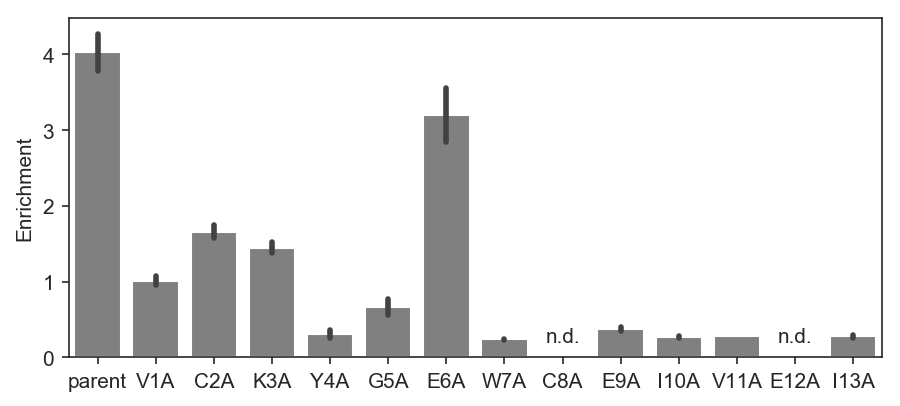

In [ ]:
fig, ax = plt.subplots(figsize = (7,3))

sns.barplot(x = 'name', y = 'enrich', data= ala_enrich_df, ax = ax, color = 'grey')

ax.set_ylabel('Enrichment')
ax.set_xlabel('')
ax.text(8, 0.2, "n.d.", ha = 'center')
ax.text(12, 0.2, "n.d.", ha = 'center')

Looks good!

## Look for allowance at each position

In [ ]:
# Look at dataframe of all possible substitutions
var_df.head()

,var_name,var_tl,var_pos,var_sub
0,I1A,ARAYVCKYGEWCEIVEI,1,A
1,I1R,RRAYVCKYGEWCEIVEI,1,R
2,I1N,NRAYVCKYGEWCEIVEI,1,N
3,I1D,DRAYVCKYGEWCEIVEI,1,D
4,I1C,CRAYVCKYGEWCEIVEI,1,C


In [ ]:
enriches_df_no_idx = enriches_df.reset_index()
enriches_df_no_idx.head()

,sample,core_seq,tl,counts,frac_reads,enrich
0,1_slDAA263_1,"(A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(K, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",98,0.001430,NaN
1,1_slDAA263_1,"(A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, ...","(N, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",124,0.001810,NaN
2,1_slDAA263_1,"(A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",180,0.002627,NaN
3,1_slDAA263_1,"(A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, ...","(T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",182,0.002657,NaN
4,1_slDAA263_1,"(A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(R, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",77,0.001124,NaN


In [ ]:
# Merge variants df onto the enrichment df
var_enrich_df = pd.merge(enriches_df_no_idx, var_df, how = 'left', left_on = 'tl', right_on = 'var_tl')
var_enrich_df.head()

,sample,core_seq,tl,counts,frac_reads,enrich,var_name,var_tl,var_pos,var_sub
0,1_slDAA263_1,"(A, A, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(K, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",98,0.001430,NaN,I1K,KRAYVCKYGEWCEIVEI,1.0,K
1,1_slDAA263_1,"(A, A, T, C, G, C, G, C, G, T, A, C, G, T, G, ...","(N, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",124,0.001810,NaN,I1N,NRAYVCKYGEWCEIVEI,1.0,N
2,1_slDAA263_1,"(A, C, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",180,0.002627,NaN,I1T,TRAYVCKYGEWCEIVEI,1.0,T
3,1_slDAA263_1,"(A, C, T, C, G, C, G, C, G, T, A, C, G, T, G, ...","(T, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",182,0.002657,NaN,I1T,TRAYVCKYGEWCEIVEI,1.0,T
4,1_slDAA263_1,"(A, G, G, C, G, C, G, C, G, T, A, C, G, T, G, ...","(R, R, A, Y, V, C, K, Y, G, E, W, C, E, I, V, ...",77,0.001124,NaN,I1R,RRAYVCKYGEWCEIVEI,1.0,R


### Plot a single position's allowance

In [ ]:
parent

'IRAYVCKYGEWCEIVEI'

In [ ]:
parent[9]

'E'

In [ ]:
def single_pos_plt(sample,pos):
    sub_df = var_enrich_df[(var_enrich_df['sample'] == sample) & (var_enrich_df['var_pos'] == pos)]   

    fig, ax = plt.subplots(figsize = (11,2.5))

    sns.barplot(x = 'var_name', y = 'enrich', data = sub_df, ax = ax, color = 'grey')
    
    # pull out parental and plot as a line
    parent_df = sub_df[sub_df['var_sub'] == parent[pos-1]]
    parent_enrich = parent_df['enrich'].mean()
    plt.hlines(parent_enrich,-1,21, linestyles = 'dashed')
    ax.set_xlim(-1, 21)
    ax.set_xlabel('AA substitution')
    ax.set_ylabel('Enrichment')
    
    plt.show()

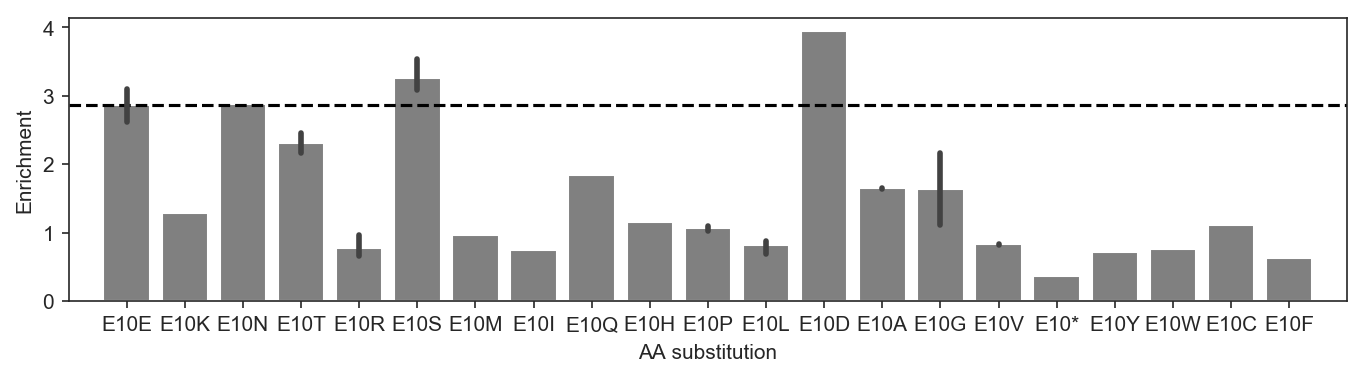

In [ ]:
single_pos_plt('4_slDAA265', 10)

## Plot all positions together

In [ ]:
def enrich_heatmap(sample, ax):
    
    sub_df = var_enrich_df[(var_enrich_df['sample'] == sample)]
    
    ## First w/ need to take the mean of all variants and pivot on the positions
    var_enrich_median = sub_df.groupby(['var_pos', 'var_sub']).median().reset_index()
    var_enrich_pivot = var_enrich_median.pivot_table(index = 'var_sub', columns = 'var_pos', values = 'enrich')
    
    sns.heatmap(var_enrich_pivot, ax = ax, cmap = 'vlag',
                  xticklabels = [a for a in parent], cbar_kws={'label': 'Variant enrichment'}, vmin = 1e-2,vmax = 1e2,
                  norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=1e2))
    
    ax.set_title(sample)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position('left')
    ax.set_yticklabels(ax.get_yticklabels(), rotation= 0)
    ax.set_xlabel('')
    ax.set_facecolor('#000000')
    ax.set_xlabel('Core position')
    ax.set_ylabel('AA substitution')
    

C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


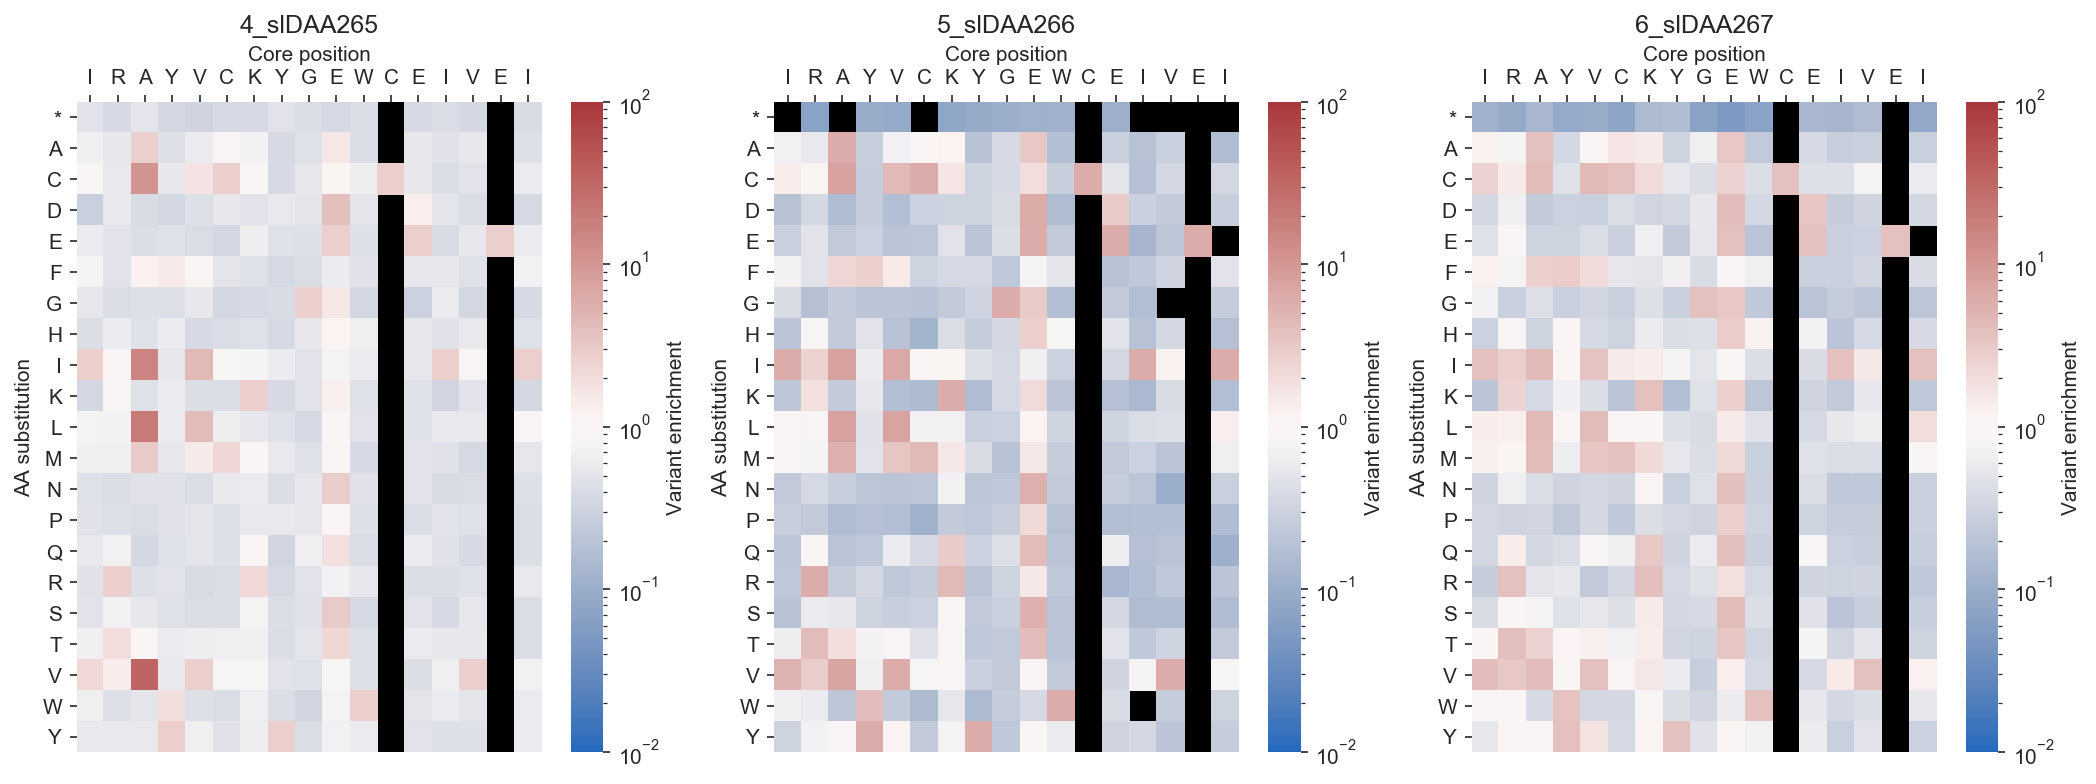

In [ ]:
fig, axs = plt.subplots(figsize = (17,5.74), ncols = 3)

for sample, ax  in zip(['4_slDAA265', '5_slDAA266', '6_slDAA267'],axs):
    enrich_heatmap(sample, ax)

### Clustermaps
* moves around (clusters) the substitutions, so not as easy to look at 

In [ ]:
def enrich_clustermap(sample):
    
    sub_df = var_enrich_df[(var_enrich_df['sample'] == sample)]
    
    ## First w/ need to take the mean of all variants and pivot on the positions
    var_enrich_median = sub_df.groupby(['var_pos', 'var_sub']).median().reset_index()
    var_enrich_pivot = var_enrich_median.pivot_table(index = 'var_sub', columns = 'var_pos', values = 'enrich')
    
    # Fill NaNs w/ enrichment score of 1
    g = sns.clustermap(var_enrich_pivot.fillna(value = 1), col_cluster = False,
                  mask = var_enrich_pivot.isnull(), cmap = 'vlag', dendrogram_ratio = 0.1, cbar_pos=(0.95, .25, .05, .5),
                  xticklabels = [a for a in parent], figsize = (4.5,5.74), cbar_kws={'label': 'Variant enrichment'}, vmin = 1e-2,vmax = 1e2,
                  norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=1e2))

    g.ax_heatmap.xaxis.tick_top()
    g.ax_heatmap.xaxis.set_label_position('top')
    g.ax_heatmap.yaxis.tick_left()
    g.ax_heatmap.yaxis.set_label_position('left')
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation= 0)
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_facecolor('#000000')
    g.ax_heatmap.set_xlabel('Core position')
    g.ax_heatmap.set_ylabel('AA substitution')

    plt.show()

In [ ]:
seq_data['sample'].unique()

array(['1_slDAA263_1', '2_slDAA263_2', '3_slDAA264', '4_slDAA265',
       '5_slDAA266', '6_slDAA267', '7_slDAA268'], dtype=object)

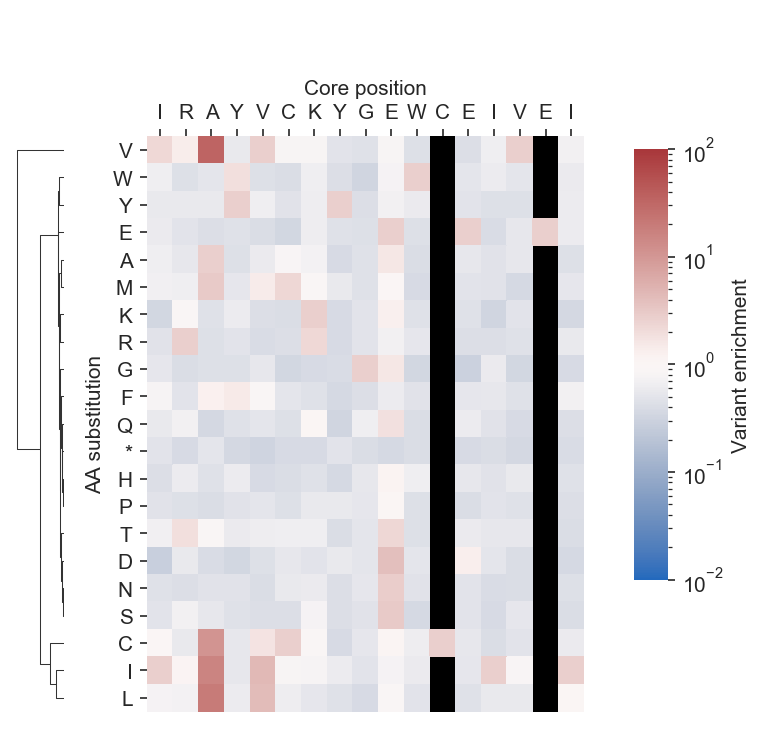

In [ ]:
enrich_clustermap('4_slDAA265')

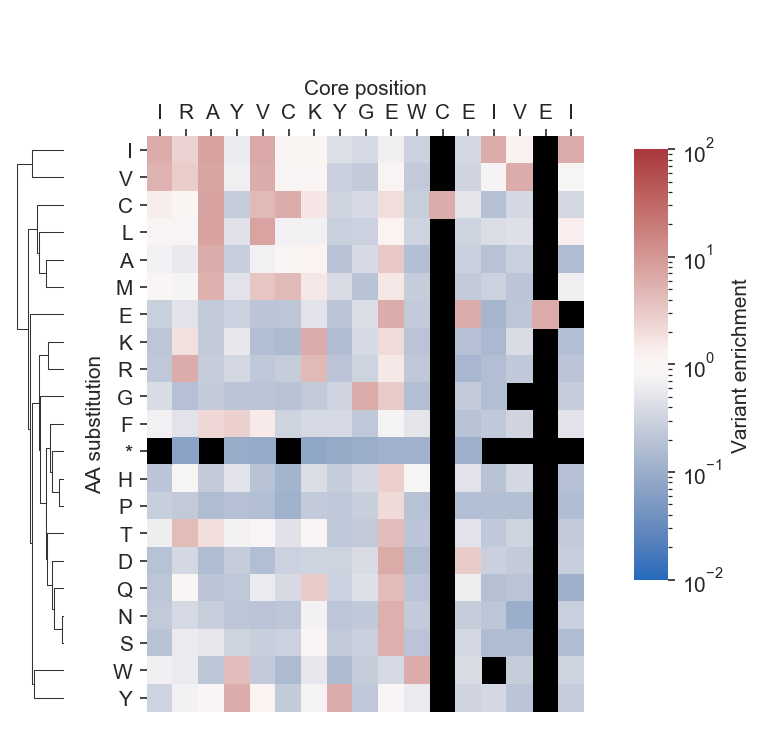

In [ ]:
enrich_clustermap('5_slDAA266')

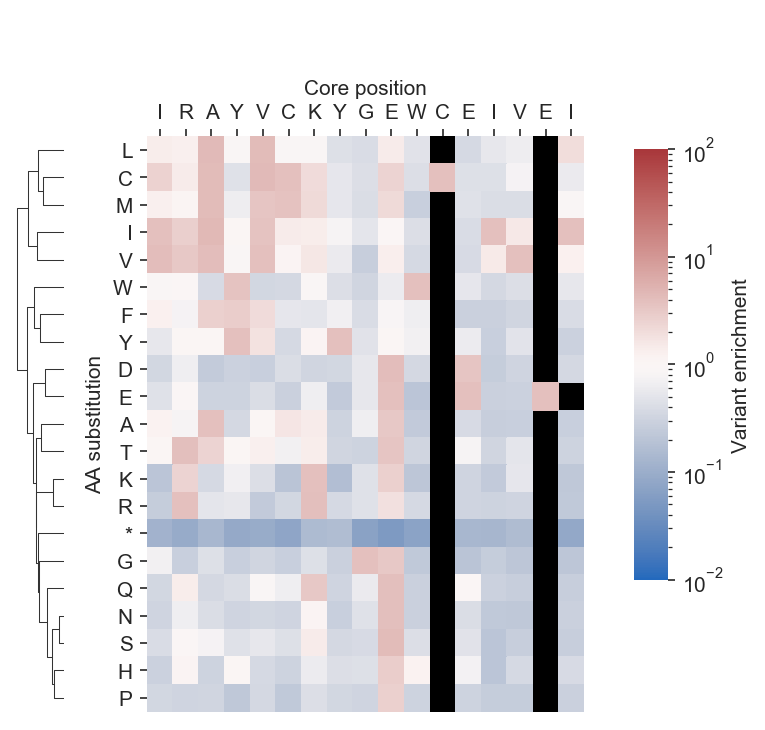

In [ ]:
enrich_clustermap('6_slDAA267')

## Enrichment relative to parental
* since we're looking for better binders, we want to normalize enrichments for each variant to be relative to the parental enrichment values

In [ ]:
def enrich_norm_heatmap(sample, ax):
    
    sub_df = var_enrich_df[(var_enrich_df['sample'] == sample)]
    
    ## First w/ need to take the mean of all variants and pivot on the positions
    var_enrich_median = sub_df.groupby(['var_pos', 'var_sub']).median().reset_index()

    # Pull out parental sequence enrichment value
    parent_enrich = var_enrich_median[(var_enrich_median['var_pos'] == 1) & (var_enrich_median['var_sub'] == 'I')]['enrich'].values[0]
    var_enrich_median['norm_enrich'] = var_enrich_median['enrich'] / parent_enrich

    var_enrich_pivot = var_enrich_median.pivot_table(index = 'var_sub', columns = 'var_pos', values = 'norm_enrich')
    
    sns.heatmap(var_enrich_pivot, ax = ax, cmap = 'vlag',
                  xticklabels = [a for a in parent], cbar_kws={'label': 'Enrichment relative to parent'}, vmin = 1e-1,vmax = 1e1,
                  norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=1e1))
    
    ax.set_title(sample)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position('left')
    ax.set_yticklabels(ax.get_yticklabels(), rotation= 0)
    ax.set_xlabel('')
    ax.set_facecolor('#000000')
    ax.set_xlabel('Core position')
    ax.set_ylabel('AA substitution')
    

In [ ]:
fig, axs = plt.subplots(figsize = (17,5.74), ncols = 3)

for sample, ax  in zip(['4_slDAA265', '5_slDAA266', '6_slDAA267'],axs):
    enrich_norm_heatmap(sample, ax)

C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
C:\Users\Dan\Anaconda3\envs\cf_upd_seaborn\lib\site-packages\matplotlib\colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


## Plot for paper

In [ ]:
# Export
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.transparent'] = True

In [ ]:
fig, ax = plt.subplots(figsize = (4,4.5))

enrich_norm_heatmap('4_slDAA265', ax)

plt.savefig(r"C:\Users\Dan\Dropbox (MIT)\COVID manuscript\figures\python_figures" + "/" + '4_slDAA265_IRAY_NNK_RBD_enrich.pdf' )
plt.show()

### Look at each position individually

In [ ]:
single_pos_plt('4_slDAA265', 3)

In [ ]:
single_pos_plt('4_slDAA265', 5)

In [ ]:
single_pos_plt('4_slDAA265', 10)

### Results for single substitution better binders
* looks like A3 -> C,I,L,V are really good (V is by far the best)
* V5 -> I, L are good
* E10 -> D, S are decent

In [ ]:
from IPython.display import display, HTML

# Query single subsitutions
def query_sub(sample = sample, pos = pos, sub = sub):
    sub_df = var_enrich_df[(var_enrich_df['sample'] == sample) & (var_enrich_df['var_pos'] == pos) & (var_enrich_df['var_sub'] == sub)]
    display(HTML(sub_df.to_html()))

In [ ]:
query_sub('1_slDAA263_1', 3, 'V')

### Look at off-target enrichment

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
enrich_norm_heatmap('7_slDAA268', ax)

### Results
* only R2W had a significant enrichment... could just be non-specific
* or could be expression-level change
* this doesn't show up as an interesting substitution in the on-target selections, so I'm not too worries about it

## Exporting for weblogo

Method:
- make amino acid substitutions proportional to their enrichment values
- put gaps everywhere else (so that we don't bias it towards wild-type)

In [ ]:
var_enrich_pivot

In [ ]:
# Iterate through all sequences and create a fake set of them
parent_gaps = '-------------'
alignment = []
scale_factor = 15 # How many sequences to produce for each "enrichment value"

for index, row in var_enrich_pivot.reset_index().iterrows():
    # Get the substitution value
    sub_val = row['var_sub']
    
    # Iterate through all positions that have this substitution
    for i in range(13):
        if (i == 7) or (i == 11):
            continue
        enrich_score = row[i+1] # Get the enrichment value
        if np.isnan(enrich_score) == False:
            num_seqs = int(np.floor(scale_factor*enrich_score)) # Calculate number of simulated sequences to produce
            # Create the sequence w/ gaps everywhere else
            fake_seq = parent_gaps[0:i] + sub_val + parent_gaps[i+1:]
            fake_seqs = [fake_seq]*num_seqs

            alignment.extend(fake_seqs)

In [ ]:
# Convert to a fasta file
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

# Make them into sequence records
records = []
for i,sequence in enumerate(alignment):
    record = SeqRecord(Seq(sequence), id = str(i))
    records.append(record)

SeqIO.write(records, "enrichment_scaled_core.fasta", "fasta")

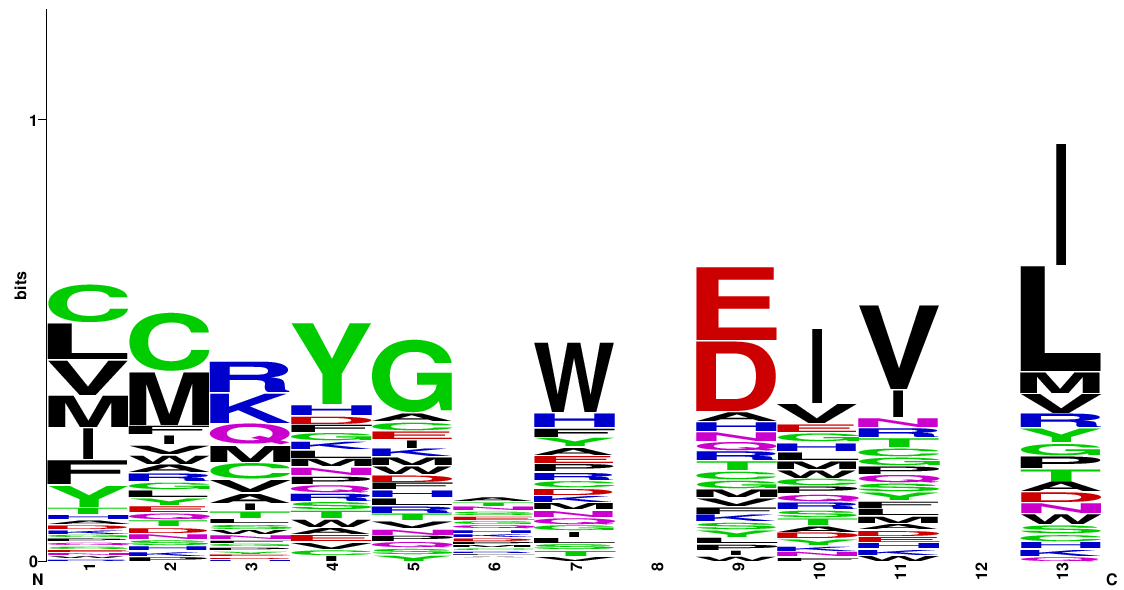

## Plot most enriched variants

In [ ]:
top_df = var_enrich_df.groupby(['var_tl', 'var_name']).mean().sort_values('enrich', ascending = False).reset_index()

In [ ]:
top_df

In [ ]:
top_vars_list = top_df.head(50)['var_tl'].unique()
top_vars_list

In [ ]:
top_vars = var_enrich_df[var_enrich_df['var_tl'].isin(top_vars_list)]

In [ ]:
fig, ax = plt.subplots(figsize = (8,4))

sns.barplot(data = top_vars, x = 'var_tl', y = 'enrich', ax = ax, order = top_vars_list )

ax.set_xticklabels(ax.get_xticklabels(), Rotation= 90 )
ax.set_xlabel('Variant')
ax.set_ylabel('Enrichment')
ax.set_ylim(0,8)

plt.show()

# Real plot for the paper

In [ ]:

import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.transparent'] = True

In [ ]:
fig, ax = plt.subplots(figsize = (4,4.5))

enrich_norm_heatmap('4_slDAA265', ax)

plt.savefig(r"C:\Users\Dan\Dropbox (MIT)\COVID manuscript\figures\python_figures" + "/" + 'IRAY_NNK_RBD_enrich.pdf' )
plt.show()